In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, learning_curve, validation_curve

In [3]:
df = pd.read_csv("~/projects/us-education-datasets-unification-project/data/us-education-datasets-unification-project/states_all.csv")

In [4]:
df.shape

(1492, 25)

In [5]:
np.sqrt(df.shape[0])
df.shape[0]/50

29.84

In [6]:
df.head(5)

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,NaN,NaN,NaN,258.859712
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,NaN


In [7]:
df.columns.tolist()

['PRIMARY_KEY',
 'STATE',
 'YEAR',
 'ENROLL',
 'TOTAL_REVENUE',
 'FEDERAL_REVENUE',
 'STATE_REVENUE',
 'LOCAL_REVENUE',
 'TOTAL_EXPENDITURE',
 'INSTRUCTION_EXPENDITURE',
 'SUPPORT_SERVICES_EXPENDITURE',
 'OTHER_EXPENDITURE',
 'CAPITAL_OUTLAY_EXPENDITURE',
 'GRADES_PK_G',
 'GRADES_KG_G',
 'GRADES_4_G',
 'GRADES_8_G',
 'GRADES_12_G',
 'GRADES_1_8_G',
 'GRADES_9_12_G',
 'GRADES_ALL_G',
 'AVG_MATH_4_SCORE',
 'AVG_MATH_8_SCORE',
 'AVG_READING_4_SCORE',
 'AVG_READING_8_SCORE']

In [8]:
set(df[df['AVG_MATH_4_SCORE']>0]['YEAR'].subtract(1).tolist())

{1991, 1995, 1999, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016}

In [9]:
shift_cols= ['PRIMARY_KEY', 'YEAR', 'STATE', 'AVG_MATH_4_SCORE']


In [10]:
df.notna().any().any()

True

In [32]:
# Function to return most recent test result
def most_recent_test(cur_yr, state, df, new_cols):
    most_recent_value= new_cols
    print(most_recent_value)
    df_scratch= df # .copy()
    df_scratch= df_scratch[df_scratch['STATE']==state]
    df_scratch= df_scratch[df_scratch['YEAR']<cur_yr]
    df_scratch.sort_values(by='YEAR')
    
    for new_col in new_cols:
        df_scratch2= df_scratch[df_scratch[new_col].notna()]
        if df_scratch2.notna().any().any(): 
            most_recent_value[new_col]= df_scratch2[new_col].iloc[-1]
        else:
            most_recent_value[new_col]= np.nan #Should handle these cases better
    return most_recent_test

In [42]:
# Function to return most recent test result
def most_recent_test(cur_yr, state, df):
    df_scratch= df # .copy()
    df_scratch= df_scratch[df_scratch['STATE']==state]
    df_scratch= df_scratch[df_scratch['YEAR']<cur_yr]
    df_scratch.sort_values(by='YEAR')

    df_scratch2= df_scratch[df_scratch['AVG_MATH_4_SCORE'].notna()]
    if df_scratch2.notna().any().any(): 
        most_recent_value= df_scratch2['AVG_MATH_4_SCORE'].iloc[-1]
    else:
        most_recent_value= np.nan #Should handle these cases better
    return most_recent_value

In [43]:
most_recent_test(2009, 'VIRGINIA', df)

243.52112978321603

In [44]:
most_recent_test(2009, 'VIRGINIA', df, ['AVG_MATH_4_SCORE', 'YEAR'])

TypeError: most_recent_test() takes 3 positional arguments but 4 were given

In [45]:
df[df['STATE']=='VIRGINIA'][df['YEAR'] <1997][['YEAR', 'AVG_MATH_4_SCORE']]

/Users/daviderickson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,YEAR,AVG_MATH_4_SCORE
46,1992,220.762964
97,1993,NaN
148,1994,NaN
199,1995,NaN
250,1996,222.643213


In [47]:
# Add recent_AVG_MATH_4_SCORE
df['recent_AVG_MATH_4_SCORE'] = np.zeros(len(df))
#new_cols= ['']
for index, data in df.iterrows(): 
    recent_test= most_recent_test(cur_yr=data['YEAR'], state=data['STATE'], df=df)
    df.loc[index, 'recent_AVG_MATH_4_SCORE']= recent_test



In [49]:
"""Failed attempts to make new recent_AVG_MATH_4_SCORE

shift_cols= ['PRIMARY_KEY', 'YEAR', 'STATE', 'AVG_MATH_4_SCORE']
df_shift= df[shift_cols].copy()
# print(df.shape, df_shift.shape)

year= df_shift['YEAR']
df_shift.loc['YEAR']= year-1
df_shift['YEAR'] = df_shift['YEAR'].astype(int)

df_shift.loc['PRIMARY_KEY']= "{}_{}".format(df_shift['YEAR'], df_shift['STATE'])
df_join= df.join(df_shift, on='PRIMARY_KEY', rsuffix='_shift')
"""

'''
print(df_join.shape)
print(df_shift['AVG_MATH_4_SCORE'].notna().sum())
print(df_join['AVG_MATH_4_SCORE_shift'].notna().sum())
print(df_join['AVG_MATH_4_SCORE'].notna().sum())

print(df_join['STATE_shift'].notna().sum())

print(df_shift['PRIMARY_KEY'])
'''

# df_join['recent_AVG_MATH_4_SCORE'] = df_join['AVG_MATH_4_SCORE_shift']
# df_join= df_join.drop(labels=['PRIMARY_KEY_shift', 'YEAR_shift', 'STATE_shift', 'AVG_MATH_4_SCORE_shift'], axis=1)

# print(df_join.shape, '\n', df_join)
# print(df_join['recent_AVG_MATH_4_SCORE'])
# print(df_join['AVG_MATH_4_SCORE'])

"\nprint(df_join.shape)\nprint(df_shift['AVG_MATH_4_SCORE'].notna().sum())\nprint(df_join['AVG_MATH_4_SCORE_shift'].notna().sum())\nprint(df_join['AVG_MATH_4_SCORE'].notna().sum())\n\nprint(df_join['STATE_shift'].notna().sum())\n\nprint(df_shift['PRIMARY_KEY'])\n"

In [ ]:
print(np.count_nonzero(~np.isnan(df['recent_AVG_MATH_4_SCORE'])))
print(np.shape(df['recent_AVG_MATH_4_SCORE']))

# print(df['recent_AVG_MATH_4_SCORE'].value_counts())

In [51]:
"""print(key, lag_key)
print(df[df['PRIMARY_KEY']==key]['GRADES_12_G'])
print()
print(df[df['PRIMARY_KEY']==lag_key]['GRADES_8_G'])
"""

"print(key, lag_key)\nprint(df[df['PRIMARY_KEY']==key]['GRADES_12_G'])\nprint()\nprint(df[df['PRIMARY_KEY']==lag_key]['GRADES_8_G'])\n"

In [52]:
#Normalize expenditures to fraction of total expenditures
expenditure_cols = ['INSTRUCTION_EXPENDITURE',
 'SUPPORT_SERVICES_EXPENDITURE',
 'OTHER_EXPENDITURE',
 'CAPITAL_OUTLAY_EXPENDITURE']

for col in expenditure_cols:
    df['fracn_exp_{}'.format(col)] = df[col] / df['TOTAL_EXPENDITURE']
    #df=df.drop(col, axis=1)
    print('fracn_exp_{}'.format(col))

fracn_exp_INSTRUCTION_EXPENDITURE
fracn_exp_SUPPORT_SERVICES_EXPENDITURE
fracn_exp_OTHER_EXPENDITURE
fracn_exp_CAPITAL_OUTLAY_EXPENDITURE


In [53]:
#Normalize revenue to fraction of total revenue
revenue_cols = ['FEDERAL_REVENUE',
 'STATE_REVENUE',
 'LOCAL_REVENUE']

for col in revenue_cols:
    df['fracn_rev_{}'.format(col)] = df[col] / df['TOTAL_REVENUE']
    #df=df.drop(col, axis=1)
    print('fracn_rev_{}'.format(col))

fracn_rev_FEDERAL_REVENUE
fracn_rev_STATE_REVENUE
fracn_rev_LOCAL_REVENUE


In [54]:
#Normalize students enrolled to fraction of enrolled population
fracn_enroll_cols = ['GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G']

for col in fracn_enroll_cols:
    df['fracn_enroll_{}'.format(col)] = df[col] / df['GRADES_ALL_G']
    print('fracn_enroll_{}'.format(col))
    #df = df.drop(col, axis=1) 

fracn_enroll_GRADES_PK_G
fracn_enroll_GRADES_KG_G
fracn_enroll_GRADES_4_G
fracn_enroll_GRADES_8_G
fracn_enroll_GRADES_12_G
fracn_enroll_GRADES_1_8_G
fracn_enroll_GRADES_9_12_G


In [55]:
df['avg_total_revenue']=df['TOTAL_REVENUE']/df['GRADES_ALL_G']
df['avg_total_expenditure'] = df['TOTAL_EXPENDITURE'] / df['GRADES_ALL_G']

df['fracn_schoolage'] = df['GRADES_ALL_G']/df['ENROLL']
df['rev_per_person'] = df['TOTAL_REVENUE'] / df['ENROLL']
df['exp_per_rev'] = df['TOTAL_EXPENDITURE'] / df['TOTAL_REVENUE']

#Models want to know about drop-out rate
df['fracn_GRADES_12div8_G'] = np.zeros(len(df))
#Subtract take ratio GRADES_12_G(YEAR)/GRADES_8_G(YEAR-4)
for state in set(df['STATE'].tolist()):
    for year in set(df['YEAR'].tolist()):
        key= "{}_{}".format(year, state)
        lag_year = year-4
        lag_key= "{}_{}".format(lag_year, state)
        if np.any(df['PRIMARY_KEY']==lag_key):
            df.loc[df['PRIMARY_KEY']==key, ['fracn_GRADES_12div8_G']]= np.divide( \
                df[df['PRIMARY_KEY']==key]['GRADES_12_G'], np.median(df[df['PRIMARY_KEY']==lag_key]['GRADES_8_G']))

/Users/daviderickson/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [106]:
print(df.shape)
print(np.count_nonzero(df['fracn_GRADES_12div8_G'].notna()))
df['fracn_GRADES_12div8_G'].describe()

(1492, 46)
1371


count    1371.000000
mean        0.708303
std         0.704127
min         0.000000
25%         0.706076
50%         0.844276
75%         0.918057
max        23.031582
Name: fracn_GRADES_12div8_G, dtype: float64

In [56]:
df.describe()

,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,...,fracn_enroll_GRADES_8_G,fracn_enroll_GRADES_12_G,fracn_enroll_GRADES_1_8_G,fracn_enroll_GRADES_9_12_G,avg_total_revenue,avg_total_expenditure,fracn_schoolage,rev_per_person,exp_per_rev,fracn_GRADES_12div8_G
count,1492.000000,1.229000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.229000e+03,...,1319.000000,1319.000000,1319.000000,1319.000000,1218.000000,1218.000000,1168.000000,1229.000000,1280.000000,1371.000000
mean,2004.433646,9.159308e+05,9.092082e+06,7.663723e+05,4.216553e+06,4.109157e+06,9.196681e+06,4.762966e+06,2.680331e+06,4.292046e+05,...,0.081975,0.068852,0.664569,0.312266,11.114131,11.185505,0.945783,10.219307,1.006872,0.708303
std,7.393983,1.065280e+06,1.174519e+07,1.145242e+06,5.543072e+06,5.482971e+06,1.197813e+07,6.293004e+06,3.353349e+06,5.340693e+05,...,0.004651,0.010823,0.027483,0.029243,19.138258,19.721030,0.085514,4.141731,0.043190,0.704127
min,1992.000000,4.386600e+04,4.656500e+05,3.102000e+04,0.000000e+00,2.209300e+04,4.816650e+05,2.655490e+05,1.399630e+05,1.154100e+04,...,0.054466,0.019712,0.563494,0.110110,2.576621,2.563009,0.019949,3.543637,0.717038,0.000000
25%,1998.000000,2.583140e+05,2.186305e+06,1.893540e+05,1.153097e+06,7.158345e+05,2.165404e+06,1.168032e+06,6.357900e+05,1.028310e+05,...,0.080119,0.062276,0.646530,0.300543,7.380779,7.395321,0.922958,7.218376,0.984550,0.706076
50%,2004.000000,6.483130e+05,5.079546e+06,4.033765e+05,2.537074e+06,2.055780e+06,5.234506e+06,2.657452e+06,1.525406e+06,2.715960e+05,...,0.082237,0.069079,0.662824,0.315040,9.847427,9.900949,0.935351,9.429099,1.006411,0.844276
75%,2011.000000,1.014528e+06,1.085985e+07,8.289660e+05,5.080939e+06,4.768680e+06,1.074519e+07,5.568028e+06,3.229651e+06,5.186000e+05,...,0.084598,0.076759,0.682337,0.329448,12.465513,12.449592,0.950903,12.056643,1.029673,0.918057
max,2017.000000,6.307022e+06,8.921726e+07,9.990221e+06,5.090457e+07,3.610526e+07,8.532013e+07,4.396452e+07,2.605802e+07,3.995951e+06,...,0.094701,0.096302,0.783009,0.372855,601.454753,620.522359,1.782240,29.948695,1.185742,23.031582


In [57]:
#sns.pairplot(df, kind='scatter')

(44, 44)


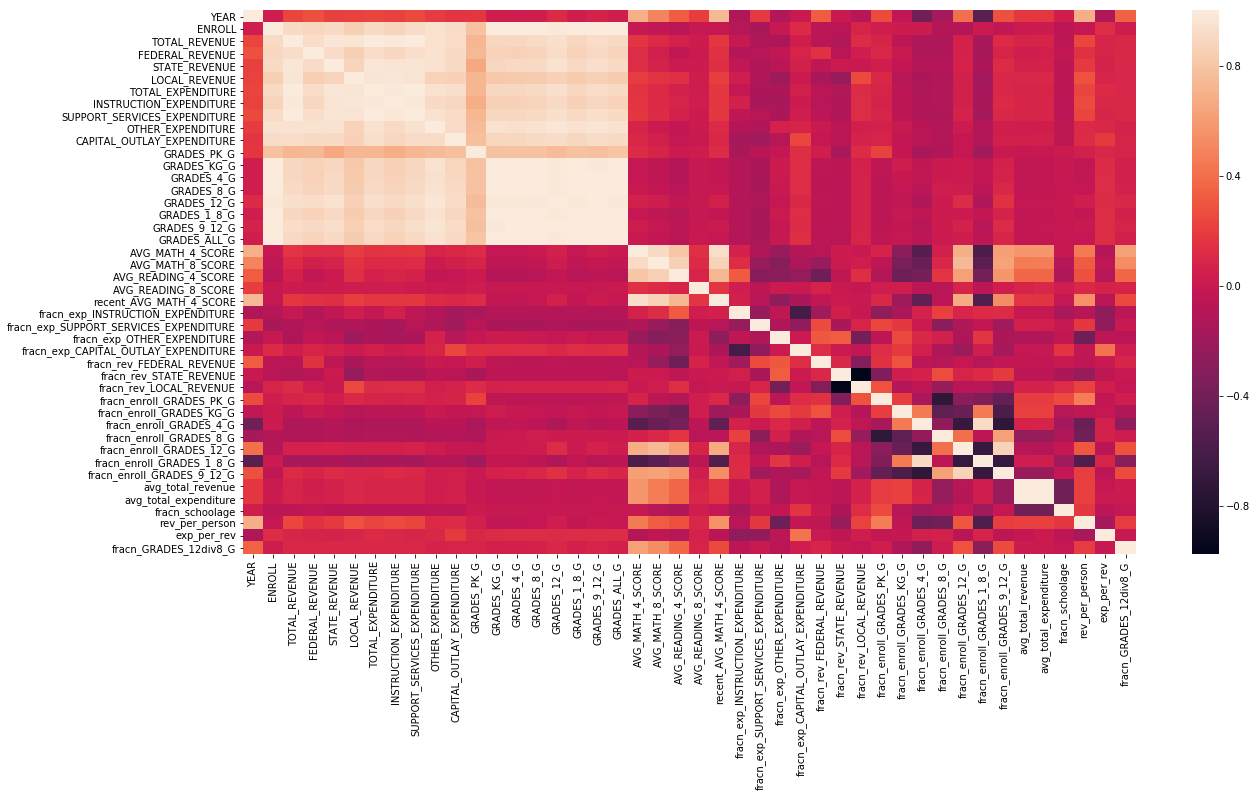

In [58]:
#plt.figure(figsize=(15,15))
corr = df.corr()
print(corr.shape)
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr)

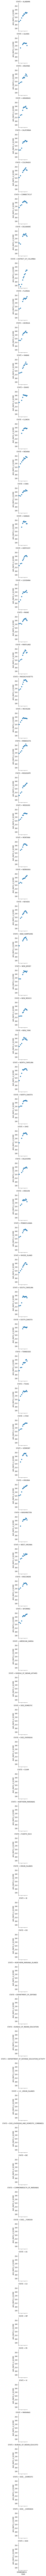

In [59]:
g = sns.FacetGrid(df, row="STATE") 
g.map(plt.scatter, 'YEAR', 'AVG_MATH_4_SCORE')

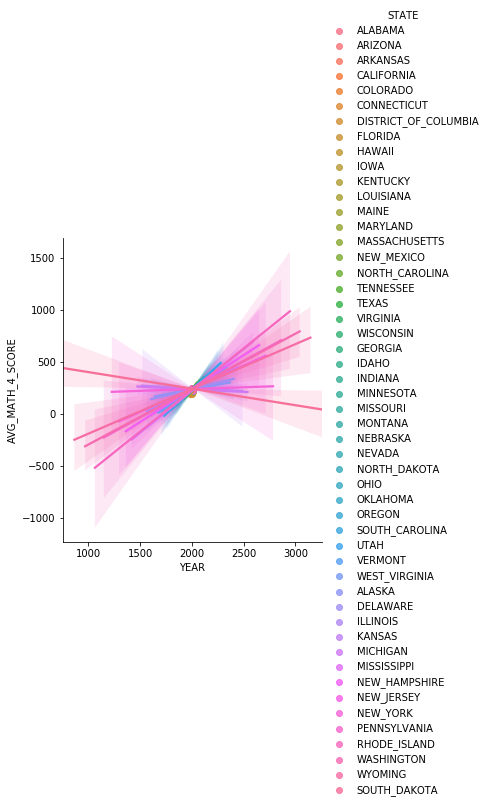

In [60]:
sns.lmplot(x="YEAR", y="AVG_MATH_4_SCORE", hue="STATE", data=df.dropna(), legend_out=True);

/Users/daviderickson/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/daviderickson/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


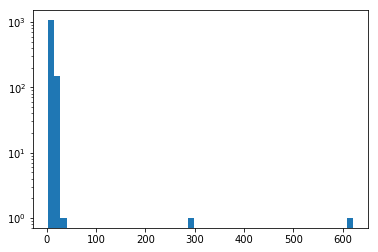

In [61]:
plt.hist('avg_total_expenditure', bins=50, log=True, data=df);

In [62]:
#For some reason VIRGINIA has 3 entries for 2008 and 2 of them have increicbly high avg_instruction_expenditure
df[df['avg_total_expenditure'] > 100]

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,fracn_enroll_GRADES_8_G,fracn_enroll_GRADES_12_G,fracn_enroll_GRADES_1_8_G,fracn_enroll_GRADES_9_12_G,avg_total_revenue,avg_total_expenditure,fracn_schoolage,rev_per_person,exp_per_rev,fracn_GRADES_12div8_G
863,2008_VIRGINIA,VIRGINIA,2008,1230857.0,14768120.0,897627.0,5957786.0,7912707.0,15236306.0,8003167.0,...,0.075236,0.049372,0.716857,0.250015,287.625280,296.743714,0.041715,11.998242,1.031702,0.026259
864,2008_VIRGINIA,VIRGINIA,2008,1230857.0,14768120.0,897627.0,5957786.0,7912707.0,15236306.0,8003167.0,...,0.060479,0.019712,0.783009,0.112324,601.454753,620.522359,0.019949,11.998242,1.031702,0.005013


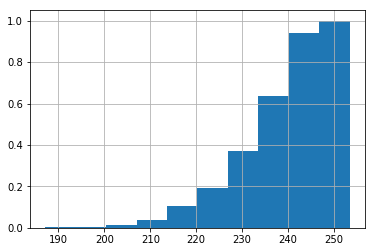

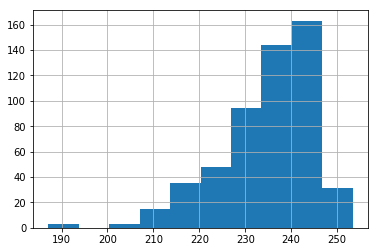

In [63]:
df['AVG_MATH_4_SCORE'].dropna().hist(density=True, cumulative=True)
plt.show()
df['AVG_MATH_4_SCORE'].dropna().hist()

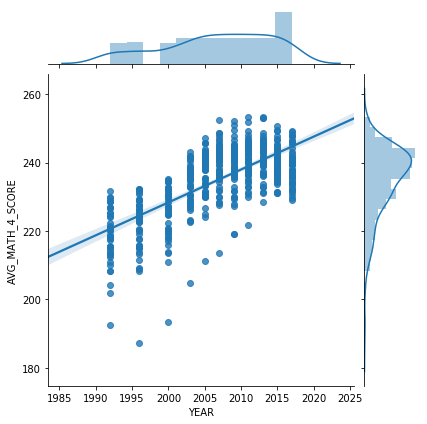

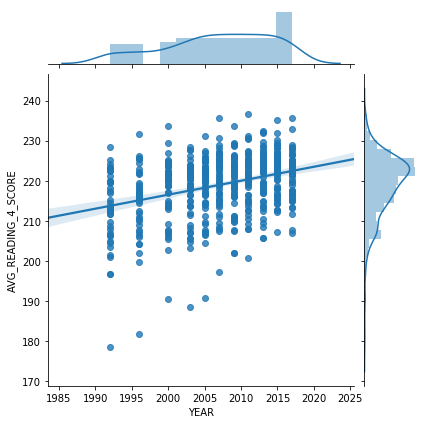

In [64]:
sns.jointplot("YEAR", "AVG_MATH_4_SCORE", data=df, kind="reg")
sns.jointplot("YEAR", "AVG_READING_4_SCORE", data=df, kind="reg")

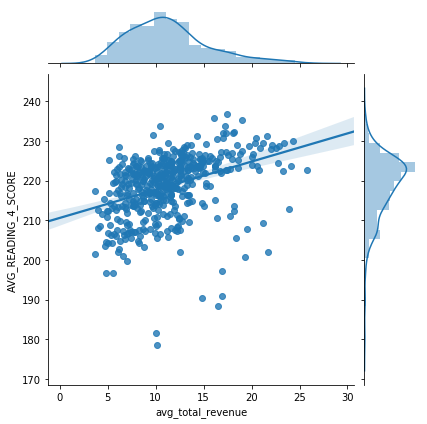

In [65]:
sns.jointplot("avg_total_revenue", "AVG_READING_4_SCORE", data=df, kind="reg")

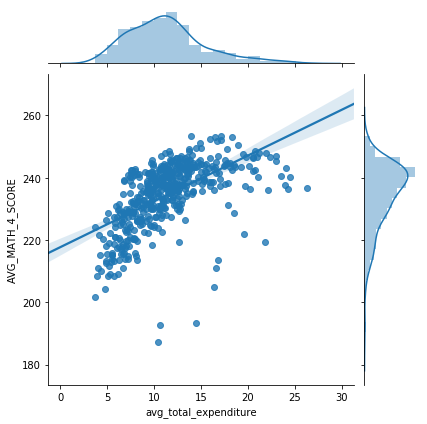

In [66]:
sns.jointplot("avg_total_expenditure", "AVG_MATH_4_SCORE", data=df, kind="reg")

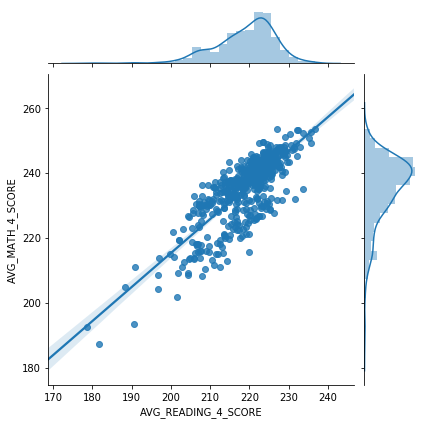

In [67]:
sns.jointplot("AVG_READING_4_SCORE", "AVG_MATH_4_SCORE", data=df, kind="reg")

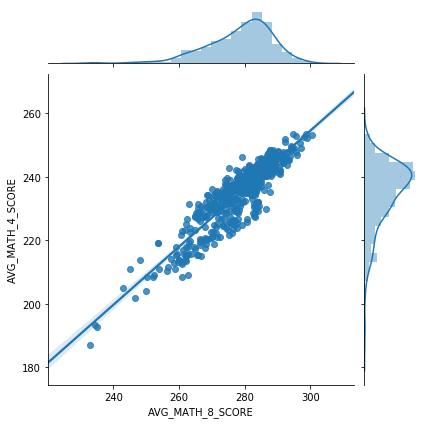

In [68]:
sns.jointplot("AVG_MATH_8_SCORE", "AVG_MATH_4_SCORE", data=df, kind="reg")

In [69]:
df1=df.drop(['PRIMARY_KEY','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE','ENROLL'],axis=1)
df1 = df1.dropna()
print(df1.columns)
df1 = pd.get_dummies(df1, columns=['STATE'])

y=df1.loc[:,'AVG_MATH_4_SCORE'].values
X=df1.drop(['AVG_MATH_4_SCORE'],axis=1).loc[:,:].values
X_cols=df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns

ts_cv = TimeSeriesSplit(n_splits=5)
print(ts_cv)
for train_index, test_index in ts_cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

"""
PredefinedSplit won't work because it folds in future data

test_fold = df1.loc[:,'YEAR'].values
ps = PredefinedSplit(test_fold)
print(ps.get_n_splits())
for train_index, test_index in ps.split():
    print("Train:", train_index, "Test:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
"""

Index(['STATE', 'YEAR', 'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE',
       'LOCAL_REVENUE', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE',
       'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE',
       'CAPITAL_OUTLAY_EXPENDITURE', 'GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G', 'GRADES_ALL_G', 'AVG_MATH_4_SCORE',
       'recent_AVG_MATH_4_SCORE', 'fracn_exp_INSTRUCTION_EXPENDITURE',
       'fracn_exp_SUPPORT_SERVICES_EXPENDITURE', 'fracn_exp_OTHER_EXPENDITURE',
       'fracn_exp_CAPITAL_OUTLAY_EXPENDITURE', 'fracn_rev_FEDERAL_REVENUE',
       'fracn_rev_STATE_REVENUE', 'fracn_rev_LOCAL_REVENUE',
       'fracn_enroll_GRADES_PK_G', 'fracn_enroll_GRADES_KG_G',
       'fracn_enroll_GRADES_4_G', 'fracn_enroll_GRADES_8_G',
       'fracn_enroll_GRADES_12_G', 'fracn_enroll_GRADES_1_8_G',
       'fracn_enroll_GRADES_9_12_G', 'avg_total_revenue',
       'avg_total_expenditure', 'fracn_schoolage', 'rev_per_pers

'\nPredefinedSplit won\'t work because it folds in future data\n\ntest_fold = df1.loc[:,\'YEAR\'].values\nps = PredefinedSplit(test_fold)\nprint(ps.get_n_splits())\nfor train_index, test_index in ps.split():\n    print("Train:", train_index, "Test:", test_index)\n    X_train, X_test = X[train_index], X[test_index]\n    y_train, y_test = y[train_index], y[test_index]    \n'

In [70]:
n_splits=20
ts_cv = TimeSeriesSplit(n_splits=n_splits)
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1)

index=0
train_score = np.zeros(n_splits)
test_score = np.zeros(n_splits)

for train_index, test_index in ts_cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]   
    
    rf_model.fit(X_train, y_train) 
    Y_rf=rf_model.predict(X_test)
    train_score[index]=rf_model.score(X_train,y_train) #Train score
    test_score[index]=rf_model.score(X_test,y_test) #Test score
    index+=1
index_list=np.arange(index)

In [71]:
print(index)
print(index_list)
print(train_score)
print(test_score)

20
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[0.93097372 0.97583367 0.97297581 0.96704421 0.97658229 0.9772496
 0.97960319 0.97681072 0.97898826 0.98002394 0.98246609 0.98246243
 0.98268814 0.98203984 0.98479248 0.98600538 0.9851744  0.98552676
 0.98577035 0.98519401]
[ 0.80630288  0.79445741 -0.51111213  0.21217235  0.39005624  0.75659432
  0.64272097  0.80387216  0.80851212  0.7481155   0.89597574  0.8911392
  0.84694741  0.91954827  0.8378      0.80395221  0.88069394  0.5202606
  0.72146046  0.78851727]


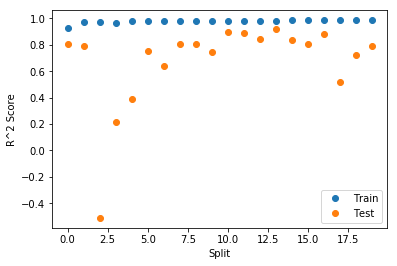

In [72]:
plt.plot(index_list,train_score,'o', label="Train")
plt.plot(index_list,test_score,'o', label="Test")
plt.xlabel("Split")
plt.ylabel("R^2 Score")
plt.legend(loc="best")

In [73]:
model=RandomForestRegressor()

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

"""
param_search = [
  {'n_estimators': [1, 10, 20, 100]}
]
gsrch_rf_model=GridSearchCV(estimator=model, param_grid=param_search, cv=ts_cv, n_jobs=-1)
gsrch_rf_model.fit(X,y)
"""

#train_sizes, train_scores, test_scores = \
#    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=10), cv=ts_cv, n_jobs=-1)

param_range=[4,5,6,7,8,9,10,20,30,40,50,60]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="n_estimators", param_range=param_range, cv=ts_cv, n_jobs=-1)

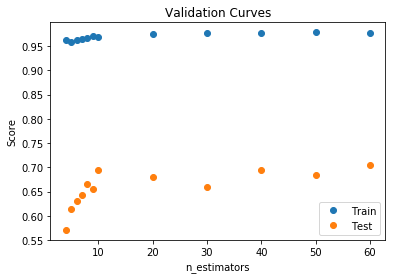

In [74]:
train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.plot(param_range,train_scores_mean,'o',label="Train")
plt.plot(param_range,test_scores_mean,'o',label="Test")
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.title("Validation Curves")
plt.legend(loc="best")

In [75]:
model=RandomForestRegressor(n_estimators=20)

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=30), cv=ts_cv, n_jobs=-1)

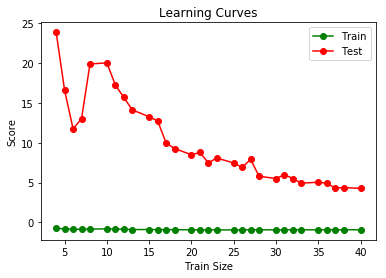

In [76]:
plt.figure()
plt.plot(train_sizes, -train_scores.mean(1), 'o-', color="g",
         label="Train")
plt.plot(train_sizes, -test_scores.mean(1), 'o-', color="r",
         label="Test")
plt.xlabel("Train Size")
plt.ylabel("Score")
plt.title("Learning Curves")
plt.legend(loc="best")

In [77]:
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X, y)  

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

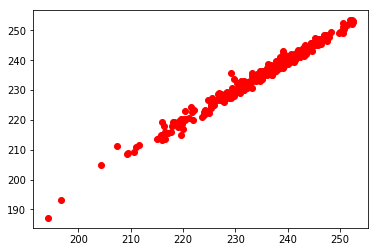

In [78]:
Y_rf=rf_model.predict(X)
plt.plot(Y_rf, y, 'ro')
plt.show()

In [79]:
rf_model.score(X,y)

0.9842877824327683

In [80]:
feature_importances_rf = pd.DataFrame(rf_model.feature_importances_, index = df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns, columns=['importance']).sort_values('importance',ascending=False)
feature_importances_rf.head(10)

,importance
recent_AVG_MATH_4_SCORE,0.886409
fracn_enroll_GRADES_8_G,0.011674
YEAR,0.007943
fracn_enroll_GRADES_12_G,0.006844
fracn_enroll_GRADES_KG_G,0.005937
fracn_enroll_GRADES_9_12_G,0.005387
fracn_enroll_GRADES_4_G,0.005294
fracn_exp_SUPPORT_SERVICES_EXPENDITURE,0.004426
fracn_GRADES_12div8_G,0.004040
fracn_rev_FEDERAL_REVENUE,0.003641


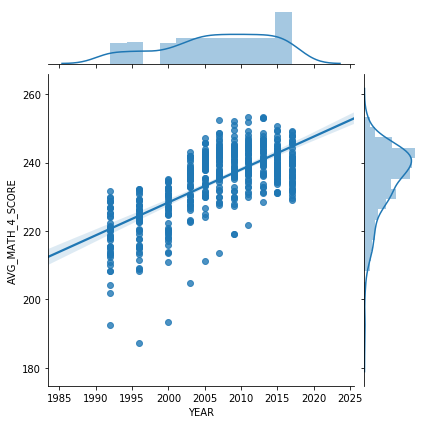

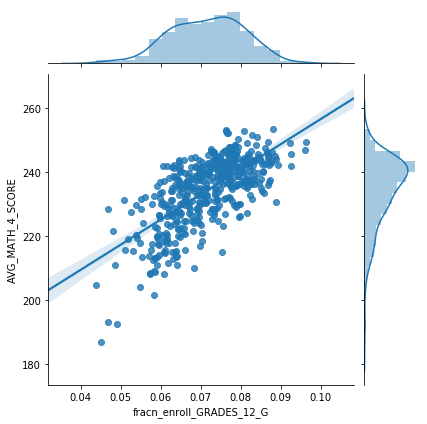

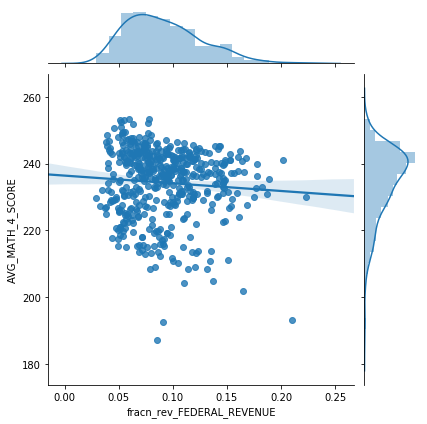

In [81]:
sns.jointplot(x='YEAR', y='AVG_MATH_4_SCORE', data=df, kind='reg')
sns.jointplot(x='fracn_enroll_GRADES_12_G', y='AVG_MATH_4_SCORE', data=df, kind='reg')
sns.jointplot(x='fracn_rev_FEDERAL_REVENUE', y='AVG_MATH_4_SCORE', data=df, kind='reg')

In [82]:
from sklearn import svm
svm_model = svm.SVR(gamma='scale')
svm_model.fit(X, y)  

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

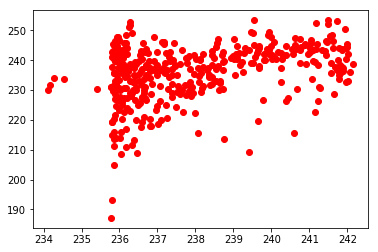

In [83]:
Y_svm=svm_model.predict(X)
plt.plot(Y_svm, y, 'ro')
plt.show()

# Lasso

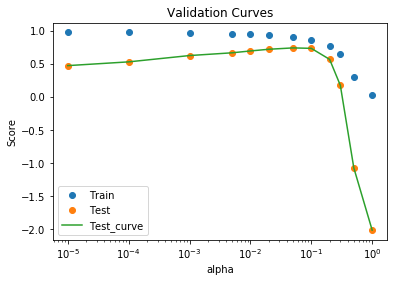

In [84]:
model=linear_model.Lasso(normalize=True)
param_search = [
  {'alpha': [0.00001,0.0001,0.001,0.01,0.1,1]}
 ]

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

#gsrch_rf_model=GridSearchCV(estimator=model, param_grid=param_search, cv=ts_cv, n_jobs=-1)
#gsrch_rf_model.fit(X,y)

#train_sizes, train_scores, test_scores = \
#    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=10), cv=ts_cv, n_jobs=-1)

param_range=[0.00001,0.0001,0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.5,1]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="alpha", param_range=param_range, cv=ts_cv, n_jobs=-1)

train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.semilogx(param_range,train_scores_mean,'o',label="Train")
plt.semilogx(param_range,test_scores_mean,'o',label="Test")
plt.semilogx(param_range,test_scores_mean,label="Test_curve")
plt.xlabel("alpha")
plt.ylabel("Score")
plt.title("Validation Curves")
plt.legend(loc="best")

(30,) (30, 5) (30, 5)


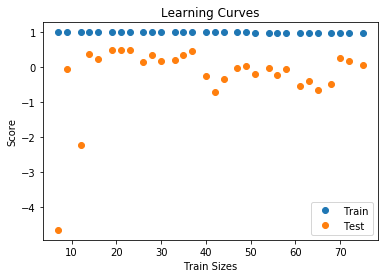

In [85]:
model=linear_model.Lasso(alpha=0.01, normalize=True)
#lasso_model.fit(X, y)  
#Y_lasso=lasso_model.predict(X)

num_splits=5
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=30), cv=ts_cv, n_jobs=-1)

print(train_sizes.shape,train_scores.shape, test_scores.shape)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes,train_scores_mean,'o',label="Train")
plt.plot(train_sizes,test_scores_mean,'o',label="Test")
plt.xlabel("Train Sizes")
plt.ylabel("Score")
plt.title("Learning Curves")
plt.legend(loc="best")

In [86]:
"""Plot test data fit"""

'Plot test data fit'

Text(0, 0.5, 'y')

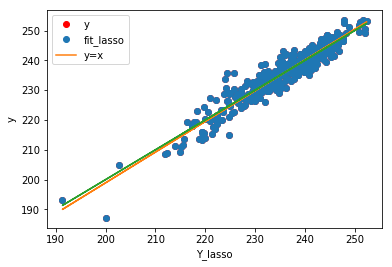

In [87]:

lasso_model=linear_model.Lasso(alpha=0.01, normalize=True)
lasso_model.fit(X, y)  
Y_lasso=lasso_model.predict(X)
plt.plot(Y_lasso, y, 'ro')

# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(Y_lasso,y)
line = slope*Y_lasso+intercept

plt.plot(Y_lasso,y,'o',Y_lasso,line,Y_lasso,Y_lasso)
plt.legend(("y","fit_lasso","y=x"),loc='best')
plt.xlabel("Y_lasso")
plt.ylabel("y")

In [88]:
lasso_coef_ = lasso_model.coef_
print(X_cols.shape)
#print(X_cols)
print(lasso_coef_.shape)
print(np.round(lasso_coef_))
#print(lasso_coef_)
X_cols[np.abs(lasso_coef_)>10]

sorted(zip(lasso_coef_.round(), X_cols))

(90,)
(90,)
[   0.    0.   -0.   -0.    0.    0.   -0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    1.   -0.   -3.  -10.    1.   -0.
   -0.    0.    0.   -5. -120.  241.    0.   -4.    0.    0.    0.    0.
    0.    0.    2.   -1.   -0.   -0.   -0.   -0.    0.    0.   -0.   -0.
    0.   -0.    0.    0.   -0.    0.   -0.    0.    0.   -0.   -0.    0.
    1.   -0.    0.   -0.   -0.   -0.   -0.   -0.    0.    0.   -1.   -0.
    0.   -0.    0.    0.   -0.   -0.   -0.   -0.   -0.   -0.    0.    0.
    0.    0.    0.   -0.    0.    0.]


[(-120.0, 'fracn_enroll_GRADES_4_G'),
 (-10.0, 'fracn_exp_OTHER_EXPENDITURE'),
 (-5.0, 'fracn_enroll_GRADES_KG_G'),
 (-4.0, 'fracn_enroll_GRADES_1_8_G'),
 (-3.0, 'fracn_exp_SUPPORT_SERVICES_EXPENDITURE'),
 (-1.0, 'STATE_ALABAMA'),
 (-1.0, 'STATE_NEW_MEXICO'),
 (0.0, 'CAPITAL_OUTLAY_EXPENDITURE'),
 (-0.0, 'FEDERAL_REVENUE'),
 (0.0, 'GRADES_12_G'),
 (0.0, 'GRADES_1_8_G'),
 (0.0, 'GRADES_4_G'),
 (0.0, 'GRADES_8_G'),
 (0.0, 'GRADES_9_12_G'),
 (0.0, 'GRADES_ALL_G'),
 (0.0, 'GRADES_KG_G'),
 (0.0, 'GRADES_PK_G'),
 (-0.0, 'INSTRUCTION_EXPENDITURE'),
 (0.0, 'LOCAL_REVENUE'),
 (0.0, 'OTHER_EXPENDITURE'),
 (-0.0, 'STATE_ALASKA'),
 (-0.0, 'STATE_ARIZONA'),
 (-0.0, 'STATE_ARKANSAS'),
 (-0.0, 'STATE_CALIFORNIA'),
 (0.0, 'STATE_COLORADO'),
 (0.0, 'STATE_CONNECTICUT'),
 (-0.0, 'STATE_DELAWARE'),
 (-0.0, 'STATE_DISTRICT_OF_COLUMBIA'),
 (0.0, 'STATE_FLORIDA'),
 (-0.0, 'STATE_GEORGIA'),
 (0.0, 'STATE_HAWAII'),
 (0.0, 'STATE_IDAHO'),
 (-0.0, 'STATE_ILLINOIS'),
 (0.0, 'STATE_INDIANA'),
 (-0.0, 'STATE_IOWA'

In [89]:
scaler=StandardScaler()
X_transformed = scaler.fit_transform(X)

model=linear_model.Lasso(alpha=0.01, normalize=True)
lasso_model.fit(X_transformed, y)  
Y_lasso=lasso_model.predict(X_transformed)

lasso_coef_ = lasso_model.coef_
print(X_cols.shape)
#print(X_cols)
print(lasso_coef_.shape)
print(np.round(lasso_coef_))
#print(lasso_coef_)
X_cols[np.abs(lasso_coef_)>10]

sorted(zip(lasso_coef_, X_cols))

(90,)
(90,)
[ 0.  0. -0. -0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  8. -0. -0. -0.  0. -0. -0.  0.  0. -0. -0.  1.  0. -0.  0.  0.  0.  0.
  0.  0.  0. -0. -0. -0. -0. -0.  0.  0. -0. -0.  0. -0.  0.  0. -0.  0.
 -0.  0.  0. -0. -0.  0.  0. -0.  0. -0. -0. -0. -0. -0.  0.  0. -0. -0.
  0. -0.  0.  0. -0. -0. -0. -0. -0. -0.  0.  0.  0.  0.  0. -0.  0.  0.]


[(-0.44078751202070204, 'fracn_enroll_GRADES_4_G'),
 (-0.18252278194841387, 'STATE_NEW_MEXICO'),
 (-0.15802899531602693, 'fracn_exp_OTHER_EXPENDITURE'),
 (-0.11293367712488375, 'STATE_ALABAMA'),
 (-0.08738917935011388, 'fracn_exp_SUPPORT_SERVICES_EXPENDITURE'),
 (-0.08373436432577065, 'fracn_enroll_GRADES_1_8_G'),
 (-0.037185539940006486, 'fracn_enroll_GRADES_KG_G'),
 (-0.025210295060946183, 'STATE_CALIFORNIA'),
 (0.0, 'CAPITAL_OUTLAY_EXPENDITURE'),
 (-0.0, 'FEDERAL_REVENUE'),
 (0.0, 'GRADES_12_G'),
 (0.0, 'GRADES_1_8_G'),
 (0.0, 'GRADES_4_G'),
 (0.0, 'GRADES_8_G'),
 (0.0, 'GRADES_9_12_G'),
 (0.0, 'GRADES_ALL_G'),
 (0.0, 'GRADES_KG_G'),
 (0.0, 'GRADES_PK_G'),
 (-0.0, 'INSTRUCTION_EXPENDITURE'),
 (0.0, 'LOCAL_REVENUE'),
 (0.0, 'OTHER_EXPENDITURE'),
 (-0.0, 'STATE_ALASKA'),
 (-0.0, 'STATE_ARIZONA'),
 (-0.0, 'STATE_ARKANSAS'),
 (0.0, 'STATE_COLORADO'),
 (0.0, 'STATE_CONNECTICUT'),
 (-0.0, 'STATE_DELAWARE'),
 (-0.0, 'STATE_DISTRICT_OF_COLUMBIA'),
 (0.0, 'STATE_FLORIDA'),
 (-0.0, 'STATE_GEO

Text(0, 0.5, 'y')

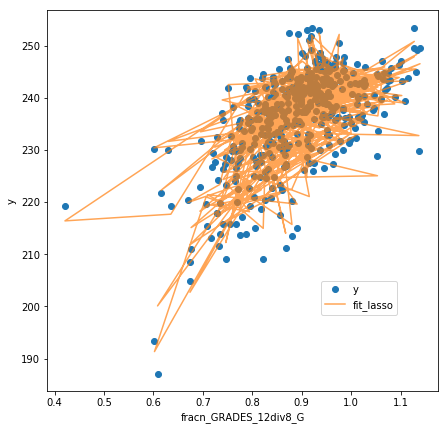

In [90]:
"""fracn_GRADES_12div8_G
is not chosen by Lasso. RandomForest says it's #2 tho. Why?
Plot.
"""
plt.figure(figsize=[7,7])
x1=df1.loc[:,'fracn_GRADES_12div8_G'].values
plt.plot(x1,y,'o')
plt.plot(x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("fracn_GRADES_12div8_G")
plt.ylabel("y")

(430,) (430, 90) (430,)
(430,) (430, 90) (430,)
(430,) (430, 90) (430,)
(430,) (430, 90) (430,)


Text(0, 0.5, 'y')

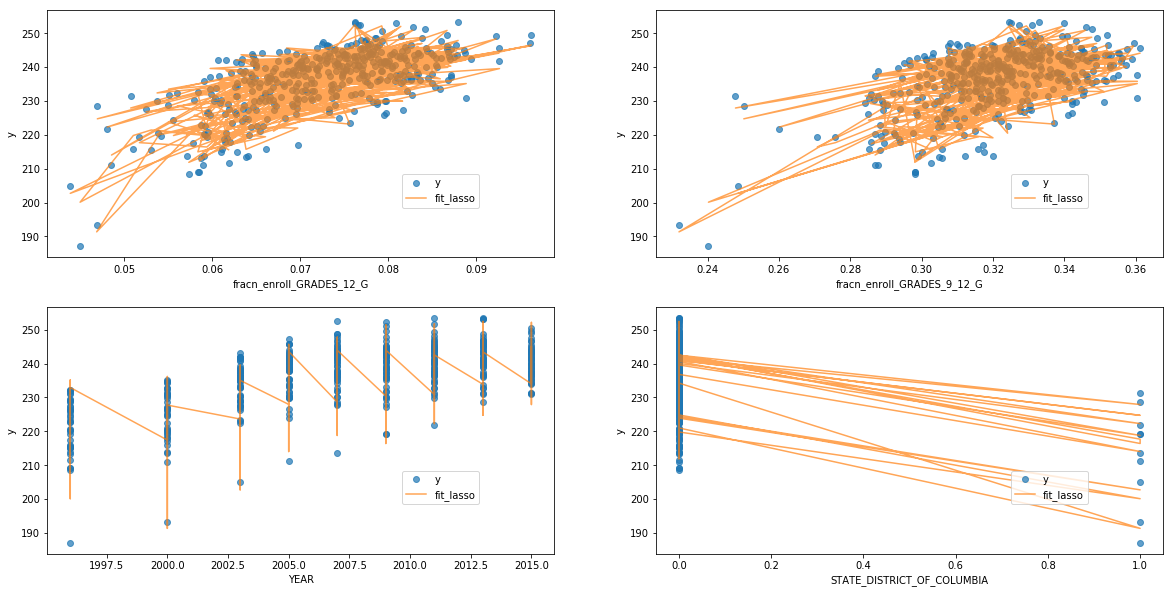

In [91]:
plt.figure(figsize=[20,10])

plt.subplot(2, 2, 1)
x1=df1.loc[:,'fracn_enroll_GRADES_12_G'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("fracn_enroll_GRADES_12_G")
plt.ylabel("y")

plt.subplot(2, 2, 2)
x1=df1.loc[:,'fracn_enroll_GRADES_9_12_G'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("fracn_enroll_GRADES_9_12_G")
plt.ylabel("y")

plt.subplot(2, 2, 3)
x1=df1.loc[:,'YEAR'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("YEAR")
plt.ylabel("y")

plt.subplot(2, 2, 4)
x1=df1.loc[:,'STATE_DISTRICT_OF_COLUMBIA'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("STATE_DISTRICT_OF_COLUMBIA")
plt.ylabel("y")

Text(0, 0.5, 'y')

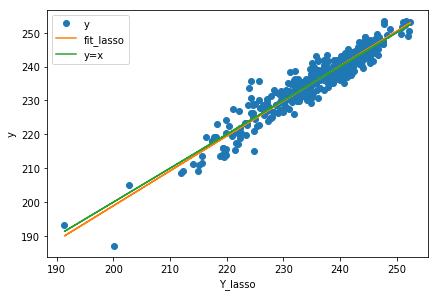

In [92]:
plt.figure(figsize=[15,10])

plt.subplot(2, 2, 1)
plt.plot(Y_lasso,y,'o',Y_lasso,line,Y_lasso,Y_lasso)
plt.legend(("y","fit_lasso","y=x"),loc='best')
plt.xlabel("Y_lasso")
plt.ylabel("y")

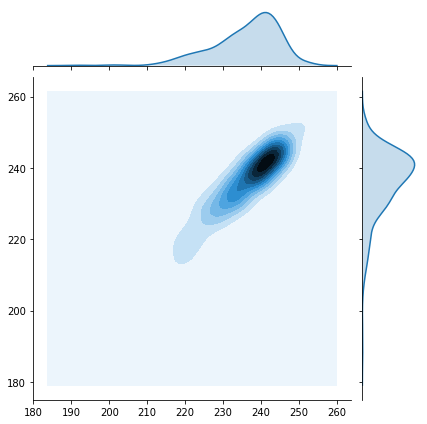

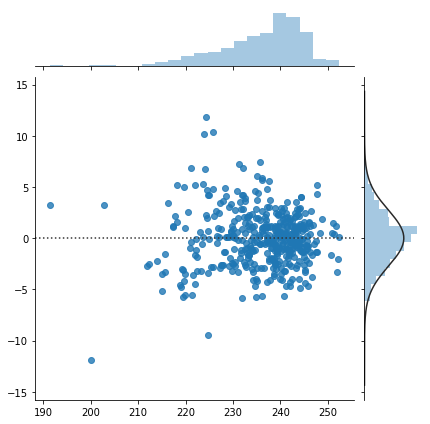

In [93]:
# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(Y_lasso,y)
line = slope*Y_lasso+intercept

#need to make analysis_df that has y,Y_lasso

#Plot
#grid=sns.JointGrid(x=Y_lasso,y=y)
#g=grid.plot_joint(sns.scatterplot) #, hue='smoker'
#sns.scatterplot(Y_lasso,line, ax=g.ax_marg_x, legend=False)
#sns.lmplot(Y_lasso,Y_lasso,ax=g.ax_marg_x,legend=False)

#plt.subplot(1,2,1)
ax1 = sns.jointplot(x=Y_lasso,y=y,kind="kde")
#plt.subplot(1,2,2)
ax2 = sns.jointplot(x=Y_lasso,y=y,kind="resid")

TypeError: 'list' object is not callable

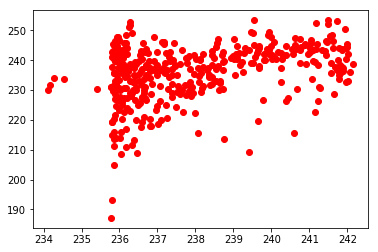

In [94]:
"""The largest coefficients are"""
X_cols[np.abs(lasso_coef_)>0.5]
""". Plot them with fits."""

plt.plot(Y_svm, y, 'ro')("YEAR", "AVG_MATH_4_SCORE", data=df, kind="reg")
sns.jointplot("YEAR", "AVG_MATH_4_SCORE", data=df, kind="reg")


In [ ]:
"""
Can I predict test scores for a year?

Handle time better. Time_series_split

Time trends: 
-Scores
-Populations
-Revenues
-Expenditures

Delta from previous time point as feature?

Features:
-Elite? financials, location, 
-Good school? school history, tax rev, district
-Trends in time? Deltas in time. more money, more students, higher scores, ...


"""